## Retrieve data from DB
PTEN:
- DMS scores: https://www.mavedb.org/score-sets/urn:mavedb:00000013-a-1
- Pairwise Alignment: https://www.ensembl.org/Homo_sapiens/Gene/Compara_Ortholog/Alignment?db=core;g=ENSG00000171862;g1=ENSDARG00000056623;hom_id=202046236;r=10:87862638-87971930

PAX6 Homeobox domain:
- https://www.mavedb.org/score-sets/urn:mavedb:00000949-a-1
- Multiple Alignment: https://www.ensembl.org/Homo_sapiens/Gene/Compara_Ortholog?db=core;g=ENSG00000007372;r=11:31784779-31817961

In [15]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

from prettytable import PrettyTable
from scipy.stats import pearsonr, spearmanr

In [2]:
# Connect to the database
conn = sqlite3.connect('compar_gen_data.db')
cursor = conn.cursor()

In [11]:
# all functions

# Print table content
def print_table(table_name, gene_name):
    table = PrettyTable()
    query = ""
    field_names = []

    if table_name == "Species":
        query = "SELECT * FROM Species"
        field_names = ["Species ID", "Species Name"]
        
    elif table_name == "Gene":
        query = "SELECT gene_id, gene_name FROM Gene ORDER BY Gene.gene_id"
        field_names = ["Gene ID", "Gene Name"]

    elif table_name == "Mutation":
        query = '''
            SELECT Mutation.mutation_id, Gene.gene_name, Species.species_name, Mutation.position, 
                   Mutation.ancestral_residue, Mutation.variant_residue
            FROM Mutation
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            JOIN Species ON Mutation.species_id = Species.species_id
        '''
        field_names = ["Mutation ID", "Gene", "Species", "Position", "Ancestral", "Variant"]

    elif table_name == "DMS":
        query = f'''
            SELECT DMS.dms_id, Gene.gene_name, Mutation.position, Mutation.ancestral_residue, 
                   Mutation.variant_residue, DMS.score
            FROM DMS
            JOIN Mutation ON DMS.mutation_id = Mutation.mutation_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_name = '{gene_name}'
            ORDER BY Mutation.position
        '''
        field_names = ["DMS ID", "Gene", "Position", "Ancestral", "Variant", "Score"]

    elif table_name == "MSA":
        query = f'''
            SELECT MSA.msa_id, Gene.gene_name, Species.species_name, Mutation.position, Mutation.ancestral_residue, 
                   Mutation.variant_residue, ROUND(MSA.shannon_entropy, 3), ROUND(MSA.percentage_identity, 3)
            FROM MSA
            JOIN Mutation ON MSA.mutation_id = Mutation.mutation_id
            JOIN Species ON Mutation.species_id = Species.species_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_name = '{gene_name}'
                AND (Species.species_name='ENSTNIP00000016806_Tnig')
            ORDER BY Mutation.position
        '''
        field_names = ["MSA ID", "Gene", "Species", "Position", "Ancestral", "Variant", "shannon", "% identity"]

    elif table_name == "IntegratedData":
        query = f'''
            SELECT IntegratedData.integrated_data_id, Gene.gene_name, Mutation.position,
                   Mutation.ancestral_residue, Mutation.variant_residue, ROUND(IntegratedData.shannon_entropy, 3),
                   ROUND(IntegratedData.percentage_identity, 3), ROUND(IntegratedData.dms_score, 3)
            FROM IntegratedData
            JOIN Mutation ON IntegratedData.mutation_id = Mutation.mutation_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_name = '{gene_name}'
            GROUP BY Mutation.position, Mutation.ancestral_residue, Mutation.variant_residue
            ORDER BY Mutation.position
        '''
        field_names = ["IntegratedData_ID", "Gene", "Position", "Ancestral", "Variant", 
                       "Shannon", "% Identity", "DMS_score"]
        
    else:
        print(f"Table '{table_name}' is not recognized.")
        return

    cursor.execute(query)
    data = cursor.fetchall()

    table.field_names = field_names
    for row in data:
        table.add_row(row)
    
    print(f"{table_name}:")
    print(table)
    print('')

# Clean table content
def clean_table(table):
    cursor.execute(f'''
        DELETE FROM {table}
    ''')
    conn.commit()
    print(f"{table} table cleaned successfully.")

def remove_records(table, field_name, field_value):
    sql_query = f"DELETE FROM {table} WHERE {field_name} = ?"
    cursor.execute(sql_query, (field_value,))
    conn.commit()

#does not work, need to fix:
def remove_records_by_foreign_key(table, foreign_key_field, referenced_table, referenced_field, referenced_value):
    sql_query = f"SELECT {referenced_field} FROM {referenced_table} WHERE {referenced_field} = ?"
    cursor.execute(sql_query, (referenced_value,))
    referenced_ids = cursor.fetchall()
    referenced_ids = tuple(id_[0] for id_ in referenced_ids)
    sql_query = f"DELETE FROM {table} WHERE {foreign_key_field} IN ({','.join('?' * len(referenced_ids))})"
    cursor.execute(sql_query, referenced_ids)
    conn.commit()

In [46]:
# PRINT table
#print_table("Species")
#print_table("Gene", "CYP2C19")
#print_table("Mutation", "CYP2C19")
#print_table("IntegratedData", "CYP2C19")
#print_table("MSA", "CYP2C19")
#print_table("DMS", "CYP2C19")

## Visualizations

In [47]:
# visualisation functions

def plot_dms_and_entropy(gene_name):
    # Fetch data from MSA table
    msa_query = f'''
        SELECT Mutation.position, MSA.shannon_entropy
        FROM MSA
        JOIN Mutation ON MSA.mutation_id = Mutation.mutation_id
        WHERE Mutation.gene_id = (SELECT gene_id FROM Gene WHERE gene_name = '{gene_name}')
    '''
    msa_df = pd.read_sql_query(msa_query, conn)

    # Fetch data from DMS table
    dms_query = f'''
        SELECT Mutation.position, DMS.score
        FROM DMS
        JOIN Mutation ON DMS.mutation_id = Mutation.mutation_id
        WHERE Mutation.gene_id = (SELECT gene_id FROM Gene WHERE gene_name = '{gene_name}')
    '''
    dms_df = pd.read_sql_query(dms_query, conn)

    # Calculate mean DMS score for each position
    mean_dms_scores = dms_df.groupby('position')['score'].mean().reset_index()

    # Merge MSA and mean DMS score data on position
    merged_df = pd.merge(msa_df, mean_dms_scores, on='position', how='inner')

    # Sort the dataframe by position
    merged_df.sort_values('position', inplace=True)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar plot for mean DMS scores
    color = 'tab:orange'
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Mean DMS score', color=color)
    bars = ax1.bar(merged_df['position'], merged_df['score'], color=color, alpha=0.6, label='Mean DMS score')
    ax1.tick_params(axis='y', labelcolor=color)

    # Scatter plot for Shannon entropy
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Shannon entropy', color=color)
    scatter = ax2.scatter(merged_df['position'], merged_df['shannon_entropy'], color=color, label='Shannon entropy',
                          s=5, zorder=10)  # Adjust marker size
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and labels
    plt.title(f'Mean DMS score and Shannon entropy across positions {gene_name}')
    fig.tight_layout()

    # Show plot
    plt.show()
    

def visualize_correlations(gene_name, table_name, field_1, field_2, plot_type='scatter'):
    # Query to fetch data from the specified table for the given gene_name
    query = f'''
        SELECT {table_name}.{field_1}, {table_name}.{field_2}
        FROM {table_name}
        JOIN Mutation ON {table_name}.mutation_id = Mutation.mutation_id
        JOIN Gene ON Mutation.gene_id = Gene.gene_id
        WHERE Gene.gene_name = '{gene_name}'
        AND {table_name}.{field_1} IS NOT NULL
        AND {table_name}.{field_2} IS NOT NULL
    '''
    df = pd.read_sql_query(query, conn)
    
    # Calculate Pearson and Spearman correlations
    pearson_corr, pearson_p = pearsonr(df[field_1], df[field_2])
    spearman_corr, spearman_p = spearmanr(df[field_1], df[field_2])
    
    # Print correlation results
    #print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
    #print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    if plot_type == 'scatter':
        ax.scatter(df[field_1], df[field_2], alpha=0.6)
        ax.set_title(f'Scatter plot of {field_1} vs {field_2} for {gene_name}')
    elif plot_type == 'hexbin':
        hb = ax.hexbin(df[field_1], df[field_2], gridsize=50, cmap='Blues', mincnt=1)
        ax.set_title(f'Hexbin plot of {field_1} vs {field_2} for {gene_name}')
        cb = fig.colorbar(hb, ax=ax, label='Count')
    else:
        plt.close(fig)
        raise ValueError("Invalid plot_type. Supported types are 'scatter' and 'hexbin'.")
    
    ax.set_xlabel('DMS Score')
    ax.set_ylabel('Shannon Entropy')
    
    # Add Pearson and Spearman correlation values to the plot
    plt.figtext(0.15, 0.85, f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
    plt.figtext(0.15, 0.80, f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")
    
    plt.show()

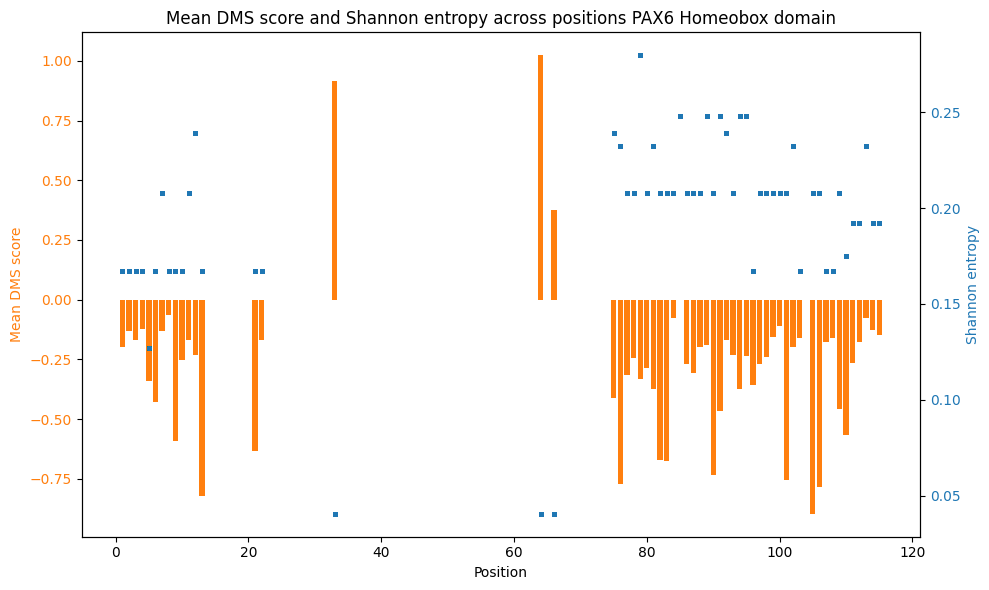

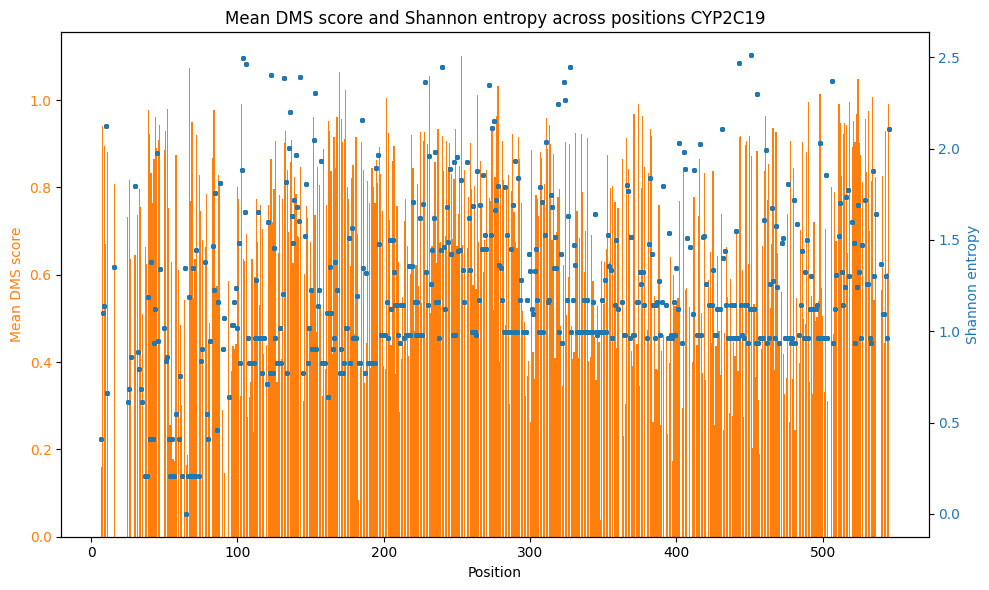

In [42]:
#PLOT mean DMS vs Shannon across positions
plot_dms_and_entropy('PAX6 Homeobox domain')
plot_dms_and_entropy('CYP2C19')

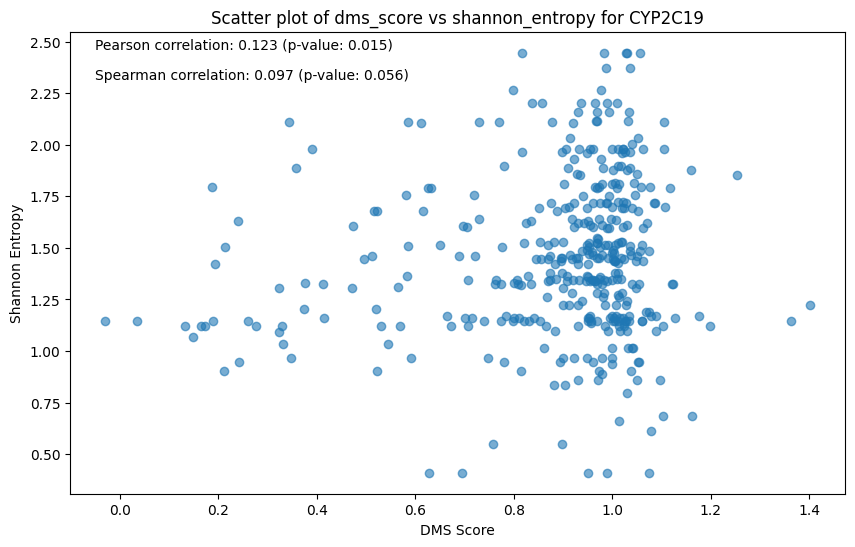

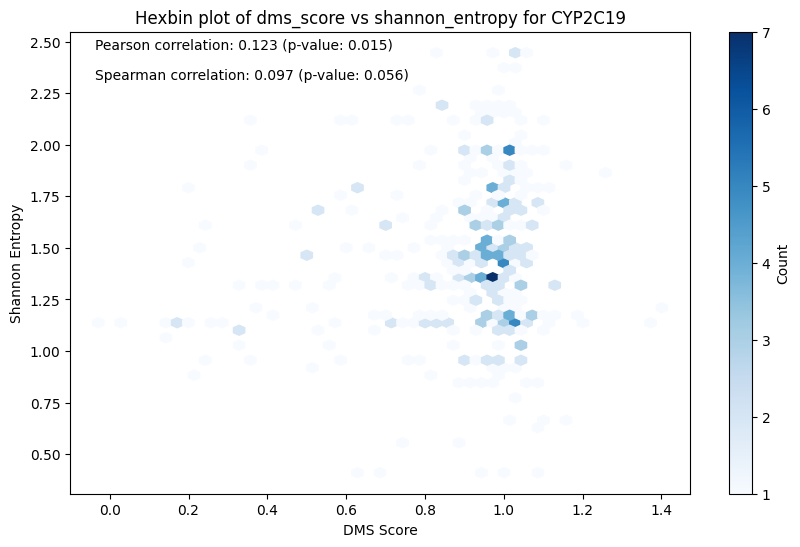

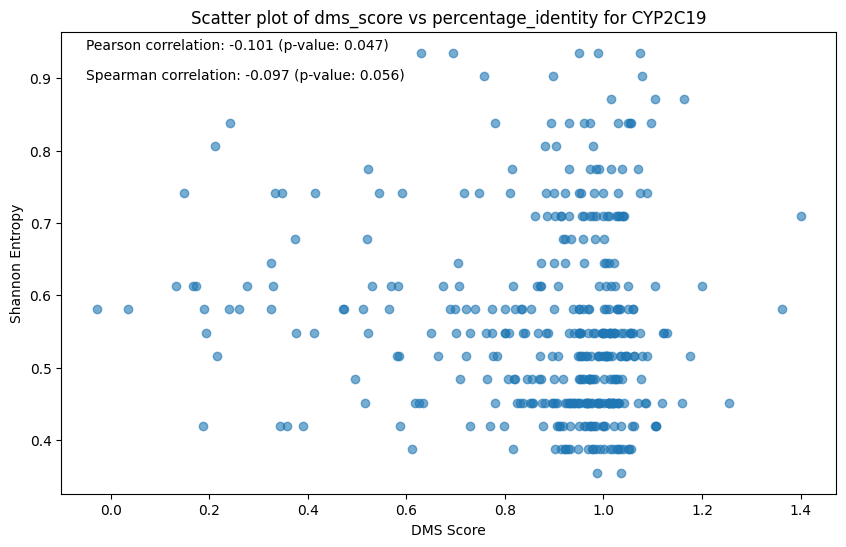

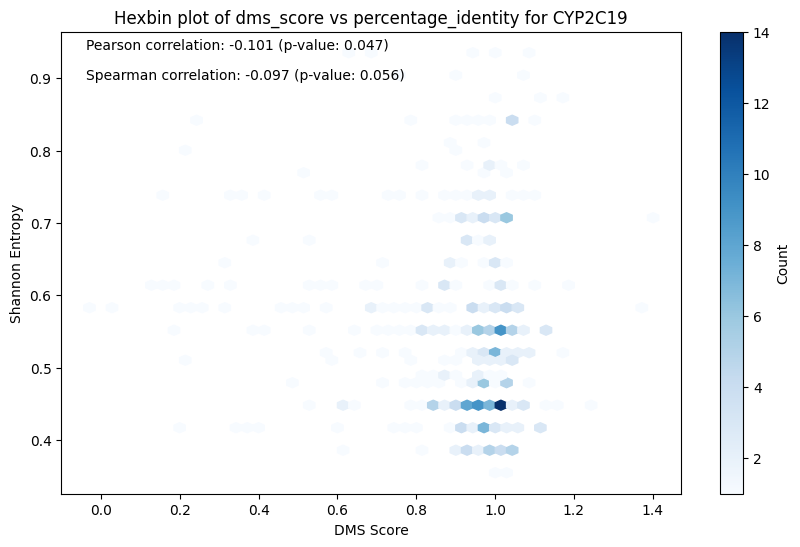

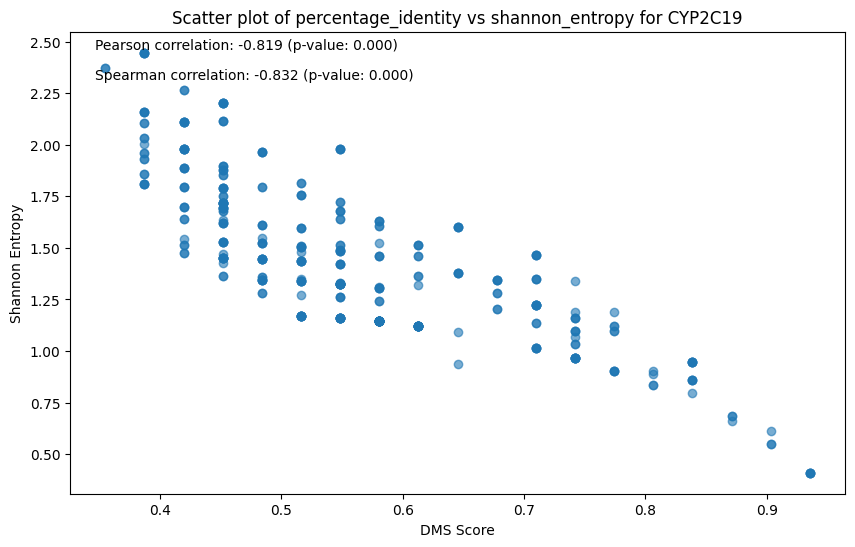

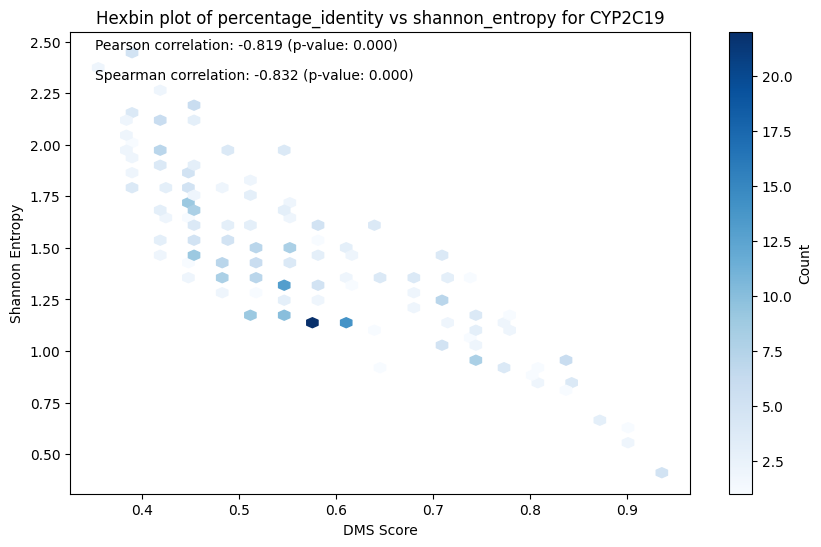

In [48]:
# PLOT correlations
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'shannon_entropy', plot_type='scatter')
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'shannon_entropy', plot_type='hexbin')
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'percentage_identity', plot_type='scatter')
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'percentage_identity', plot_type='hexbin')
visualize_correlations('CYP2C19', 'IntegratedData', 'percentage_identity', 'shannon_entropy', plot_type='scatter')
visualize_correlations('CYP2C19', 'IntegratedData', 'percentage_identity', 'shannon_entropy', plot_type='hexbin')

In [ ]:
# temporary
# CLEAN table
table_name = 'DMS'
clean_table(table_name)

#CLEAN MSA for specific gene
cursor.execute(f'''
        DELETE FROM MSA
        WHERE mutation_id IN (
            SELECT Mutation.mutation_id
            FROM Mutation
            JOIN Species ON Mutation.species_id = Species.species_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_id = 2
        );
    ''')
conn.commit()

In [ ]:
# Close the connection
conn.close()